In [47]:
import pandas as pd
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.formula.api import ols
from linearmodels.panel import PanelOLS


file_path = '/Users/rebeccluo/Downloads/US_Paid_leave_analysis.dta'

# Load the file into a DataFrame
df = pd.read_stata(file_path)
print(df.columns.tolist())

['ssuid', 'spanel', 'swave', 'srefmon', 'rhcalmn', 'rhcalyr', 'tfipsst', 'epppnum', 'esex', 'wpfinwgt', 'tage', 'eeducate', 'rmesr', 'birth_month', 'sippid', 'months', 'date', 'birth', 'birth_seen_f', 'birth_seen', 'ref_month_ns', 'ref_month', 'state', 'end_date', 'end_weight_f', 'end_weight', 'CA_date', 'NJ_date', 'post_policy', 'rm_lfp', 'working', 'looking', 'lt_college_f', 'lt_college', 'Birth', '_IBirth_2', '_IBirth_3', '_IBirth_4', '_IBirth_5', '_IBirth_6', '_IBirth_7', '_IBirth_8', '_IBirth_9', '_IBirth_10', '_IBirth_11', '_IBirth_12', '_IBirth_13', '_IBirth_14', '_IBirth_15', '_IBirth_16', '_IBirth_17', '_IBirth_18', '_IBirth_19', '_IBirth_20', '_IBirth_21', '_IBirth_22', '_IBirth_23', '_IBirth_24', '_IBirth_25', '_IBirth_26', '_IBirth_27', '_IBirth_28', '_IBirth_29', '_IBirth_30', '_IBirth_31', '_IBirth_32', '_IBirth_33', '_IBirth_34', '_IBirth_35', '_IBirth_36', '_IBirth_37', '_IBirth_38', '_IBirth_39', '_IBirth_40', '_IBirth_41', '_IBirth_42', '_IBirth_43', '_IBirth_44', '_I

In [48]:
unique_data = df.drop_duplicates(subset='sippid').dropna(subset=['rm_lfp'])
print(unique_data.shape)

(2816, 231)


In [49]:
birth_vars = [f'_IBirth_{i}' for i in range(2, 52)]  # Birth dummies from _IBirth_2 to _IBirth_51
birxpos_vars = [f'_IBirXpos_{i}_1' for i in range(2, 52)]  # Event-study dummies _IBirXpos_2_1 to _IBirXpos_50_1
llbirth_vars = [f'_LlBirth_{2}_1'] + [f'_LlBirth_{i}_1' for i in range(8, 51)]   # Reference period dummies from _LlBirth_8 to _LlBirth_50
llbipos_vars = [f'_LlBiXpos_{2}_1'] + [f'_LlBiXpos_{i}_1' for i in range(8, 51)]  # Event-study reference period _LlBiXpos_8_1 to _LlBiXpos_50_1, what we are interested in


In [50]:
import warnings

# Suppress all warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    year_dummies = pd.get_dummies(unique_data['rhcalyr'], drop_first=True)  # Time dummy for year
    birth_dummies = pd.get_dummies(unique_data[birth_vars], drop_first=False)  # Dummies for birth_vars
    state_dummies = pd.get_dummies(unique_data['state'], drop_first=True)  # Dummies for states (assuming 'state' column)
    sippid_dummies = pd.get_dummies(unique_data['sippid'], prefix='sippid', drop_first=True)
    month_dummies = pd.get_dummies(unique_data['ref_month'], prefix='month', drop_first=True)
    edu_dummies = pd.get_dummies(unique_data['lt_college'], prefix='college', drop_first=True)
    age_group_dummies = pd.get_dummies(unique_data['age_group'],prefix='age', drop_first=True)  # Dummies for age groups
    recession_dummies = pd.get_dummies(unique_data['recession_birth'],prefix='recession', drop_first=True)  # Dummies for recession years

    
    age_recession_interactions = pd.DataFrame(index=unique_data.index)
    for age_col in age_group_dummies.columns:
        for recession_col in recession_dummies.columns:
            interaction_name = f'{age_col}_recession_{recession_col}'
            age_recession_interactions[interaction_name] = age_group_dummies[age_col] * recession_dummies[recession_col]



    # Step 2: Create interaction terms between birth_vars and time (rhcalyr)
    birth_time_interactions = pd.DataFrame(index=unique_data.index)
    for birth_col in birth_dummies.columns:
        for year_col in year_dummies.columns:
            interaction_name = f'{birth_col}_time_{year_col}'
            birth_time_interactions[interaction_name] = birth_dummies[birth_col] * year_dummies[year_col]

    # Step 3: Create interaction terms between birth_vars and state
    birth_state_interactions = pd.DataFrame(index=unique_data.index)
    for birth_col in birth_dummies.columns:
        for state_col in state_dummies.columns:
            interaction_name = f'{birth_col}_state_{state_col}'
            birth_state_interactions[interaction_name] = birth_dummies[birth_col] * state_dummies[state_col]
            
    state_edu_interactions = pd.DataFrame(index=unique_data.index)
    for state_col in state_dummies.columns:
        for edu_col in edu_dummies.columns:
            interaction_name = f'{state_col}_edu_{edu_col}'  # Name the interaction term
            state_edu_interactions[interaction_name] = state_dummies[state_col] * edu_dummies[edu_col]

    state_year_interactions = pd.DataFrame(index=unique_data.index)
    for state_col in state_dummies.columns:
        for year_col in year_dummies.columns:
            interaction_name = f'{state_col}_time_{year_col}'
            state_year_interactions[interaction_name] = state_dummies[state_col] * year_dummies[year_col]

X = pd.concat([year_dummies,state_dummies,age_group_dummies,
    recession_dummies,age_recession_interactions,month_dummies,state_year_interactions,edu_dummies], axis=1)

#no missing values
X = X.fillna(0)
X.columns = X.columns.astype(str)

#complete feature matrix ready for analysis or modeling
print(X.shape)

(2816, 95)


In [51]:

X = X.reset_index(drop=True)

#Create a DataFrame for the outcome and treatment variables
outcome_treatment_df = pd.DataFrame({
    'rm_lfp': unique_data['rm_lfp'].values,           # Outcome variable
    'post_policy': unique_data['post_policy'].values   # Treatment variable
})

#Concatenate the feature matrix 
if isinstance(X, list):
    X = pd.DataFrame(X)

propensity_data = pd.concat([X, outcome_treatment_df], axis=1)
outcome_treatment_df = outcome_treatment_df.reset_index(drop=True)


print("Shape of the propensity data DataFrame:", propensity_data.shape)
print(propensity_data.head())  


Shape of the propensity data DataFrame: (2816, 97)
    1996   1997   1998   1999   2000   2001   2002   2003   2004   2005  ...  \
0  False  False   True  False  False  False  False  False  False  False  ...   
1  False  False   True  False  False  False  False  False  False  False  ...   
2  False  False  False   True  False  False  False  False  False  False  ...   
3   True  False  False  False  False  False  False  False  False  False  ...   
4  False   True  False  False  False  False  False  False  False  False  ...   

   Texas_time_2006  Texas_time_2007  Texas_time_2008  Texas_time_2009  \
0            False            False            False            False   
1            False            False            False            False   
2            False            False            False            False   
3            False            False            False            False   
4            False            False            False            False   

   Texas_time_2010  Texas_tim

In [52]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

# Step 1: Define the treatment variable
treatment = propensity_data['post_policy']  # Treatment variable (0 or 1)
X_psm = propensity_data.drop(columns=['rm_lfp', 'post_policy'])  # Drop outcome and treatment variables

# Step 2: Estimate Propensity Scores
ps_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    penalty='l1',  # Add L1 regularization
    solver='liblinear',  # Better for small datasets
    class_weight='balanced'  # Handle potential imbalance
)
ps_model.fit(X_psm, treatment)  # Fit the model to covariates and treatment
propensity_scores = ps_model.predict_proba(X_psm)[:, 1]  # Get the propensity scores

# Step 3: Add Propensity Scores 
propensity_data['propensity_score'] = propensity_scores  # Add propensity scores to propensity_data
print(propensity_data.head())
caliper = 0.2

# Step 4: Perform Nearest Neighbor Matching 
# Split into treated and control groups based on the treatment variable
treated = propensity_data[propensity_data['post_policy'] == 1]  
control = propensity_data[propensity_data['post_policy'] == 0]  

def check_balance(matched_df, treatment_col):
    balance_stats = {}
    treated_vals = matched_df[matched_df[treatment_col] == 1]
    control_vals = matched_df[matched_df[treatment_col] == 0]

    # Exclude 'rm_lfp' 
    columns_to_check = [col for col in matched_df.columns if col not in [treatment_col, 'propensity_score', 'rm_lfp']]
    
    for col in columns_to_check:
        std_diff = (treated_vals[col].mean() - control_vals[col].mean()) / \
                   ((treated_vals[col].std() + control_vals[col].std()) / 2)
        balance_stats[col] = {
            'treated_mean': treated_vals[col].mean(),
            'control_mean': control_vals[col].mean(),
            'std_diff': std_diff
        }
    
    return pd.DataFrame(balance_stats).T


nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control[['propensity_score']])
distances, indices = nbrs.kneighbors(treated[['propensity_score']])  # Find nearest neighbors

caliper_mask = distances.flatten() <= caliper
matched_indices = indices.flatten()[caliper_mask]
matched_control = control.iloc[matched_indices]  # Get matched controls based on indices within the caliper

matched_data = pd.concat([treated, matched_control])

final_balance_stats = check_balance(matched_data, 'post_policy')
print("\nBalance after caliper matching:")
print(final_balance_stats)


print("\nMatched data shape:", matched_data.shape)


    1996   1997   1998   1999   2000   2001   2002   2003   2004   2005  ...  \
0  False  False   True  False  False  False  False  False  False  False  ...   
1  False  False   True  False  False  False  False  False  False  False  ...   
2  False  False  False   True  False  False  False  False  False  False  ...   
3   True  False  False  False  False  False  False  False  False  False  ...   
4  False   True  False  False  False  False  False  False  False  False  ...   

   Texas_time_2007  Texas_time_2008  Texas_time_2009  Texas_time_2010  \
0            False            False            False            False   
1            False            False            False            False   
2            False            False            False            False   
3            False            False            False            False   
4            False            False            False            False   

   Texas_time_2011  Texas_time_2012  college_1.0  rm_lfp  post_policy  \
0      

/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_21463/1514148312.py:39: RuntimeWarning: invalid value encountered in scalar divide
  std_diff = (treated_vals[col].mean() - control_vals[col].mean()) / \
/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_21463/1514148312.py:39: RuntimeWarning: invalid value encountered in scalar divide
  std_diff = (treated_vals[col].mean() - control_vals[col].mean()) / \
/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_21463/1514148312.py:39: RuntimeWarning: invalid value encountered in scalar divide
  std_diff = (treated_vals[col].mean() - control_vals[col].mean()) / \
/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_21463/1514148312.py:39: RuntimeWarning: invalid value encountered in scalar divide
  std_diff = (treated_vals[col].mean() - control_vals[col].mean()) / \
/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_21463/1514148312.py:39: RuntimeWarning: invalid value encountered in scalar divide
  std_

/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_21463/3757986685.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(trimmed_propensity_scores[treated_trimmed], label='Treated (post_policy=1)', shade=True, color='blue')
/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_21463/3757986685.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(trimmed_propensity_scores[control_trimmed], label='Control (post_policy=0)', shade=True, color='red')


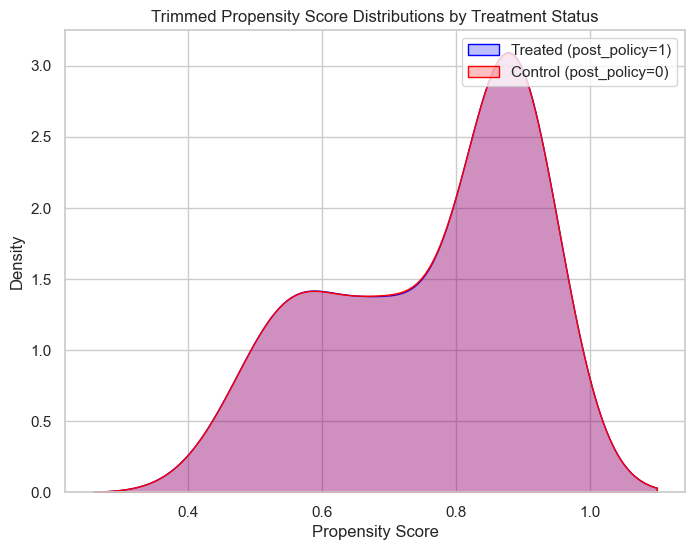

In [53]:
# Recalculate the propensity scores for the matched data (both treated and matched controls)
import seaborn as sns
T = 'post_policy'  
matched_propensity_scores = ps_model.predict_proba(matched_data[X_psm.columns])[:, 1]

# Add the recalculated propensity scores to the matched data
matched_data['propensity_score'] = matched_propensity_scores

# Define trimming thresholds for the common support region 
trimmed_data = matched_data[(matched_data['propensity_score'] >= 0.1) & (matched_data['propensity_score'] <= 0.9)]

# Recalculate the propensity scores for the trimmed data
trimmed_propensity_scores = ps_model.predict_proba(trimmed_data[X_psm.columns])[:, 1]

# Check overlap again with trimmed data
treated_trimmed = trimmed_data[T] == 1
control_trimmed = trimmed_data[T] == 0

# Plot the trimmed propensity score distributions
plt.figure(figsize=(8, 6))
sns.kdeplot(trimmed_propensity_scores[treated_trimmed], label='Treated (post_policy=1)', shade=True, color='blue')
sns.kdeplot(trimmed_propensity_scores[control_trimmed], label='Control (post_policy=0)', shade=True, color='red')

plt.title('Trimmed Propensity Score Distributions by Treatment Status')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()


In [54]:

outcome_variable = 'rm_lfp'

# Calculate means for treated and control groups
mean_treated = matched_data[matched_data['post_policy'] == 1][outcome_variable].mean()
mean_control = matched_data[matched_data['post_policy'] == 0][outcome_variable].mean()

# Calculate ATE
ATE = mean_treated - mean_control

# Display results
print(f'Mean Outcome for Treated: {mean_treated:.4f}')
print(f'Mean Outcome for Control: {mean_control:.4f}')
print(f'Average Treatment Effect (ATE): {ATE:.4f}')


Mean Outcome for Treated: 0.6545
Mean Outcome for Control: 0.1693
Average Treatment Effect (ATE): 0.4851


Observed ATE: 0.4851
ATE from Bootstrapping: 0.4850
Standard Error: 0.0299
95% C.I.: (0.4262, 0.5432)
P-value: 0.0000


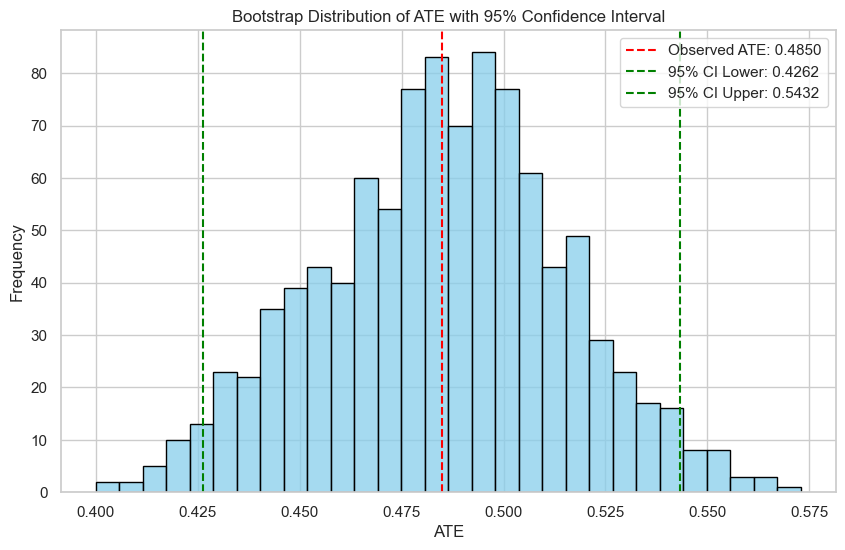

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from scipy import stats

# Function to compute ATE for a bootstrap sample
def compute_ate_bootstrap(df, outcome_var, treatment_var):
    mean_treated = df[df[treatment_var] == 1][outcome_var].mean()
    mean_control = df[df[treatment_var] == 0][outcome_var].mean()
    return mean_treated - mean_control


np.random.seed(88)
bootstrap_sample_count = 1000

# Run bootstrapping 
bootstrap_ATEs = Parallel(n_jobs=4)(
    delayed(compute_ate_bootstrap)(
        matched_data.sample(frac=1, replace=True), 
        outcome_variable, 
        T
    )
    for _ in range(bootstrap_sample_count)
)
bootstrap_ATEs = np.array(bootstrap_ATEs)

# Calculate mean ATE, standard error
ATE_mean = bootstrap_ATEs.mean()
ATE_se = bootstrap_ATEs.std()  # Standard error of the bootstrap ATEs
ci_lower, ci_upper = np.percentile(bootstrap_ATEs, [2.5, 97.5])

# Calculate the observed ATE using the full dataset
observed_ATE = (
    matched_data[matched_data[T] == 1][outcome_variable].mean() - 
    matched_data[matched_data[T] == 0][outcome_variable].mean()
)

# Calculate t-statistic and p-value 
t_stat = observed_ATE / ATE_se
degrees_of_freedom = len(matched_data) - 2  # n-2 for difference of means
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=degrees_of_freedom))

# Display results
print(f"Observed ATE: {observed_ATE:.4f}")
print(f"ATE from Bootstrapping: {ATE_mean:.4f}")
print(f"Standard Error: {ATE_se:.4f}")
print(f"95% C.I.: ({ci_lower:.4f}, {ci_upper:.4f})")
print(f"P-value: {p_value:.4f}")

# Plot the bootstrap distribution of ATE 
plt.figure(figsize=(10, 6))
sns.histplot(bootstrap_ATEs, bins=30, color='skyblue', edgecolor='black')
plt.axvline(ATE_mean, color='red', linestyle='--', label=f'Observed ATE: {ATE_mean:.4f}')
plt.axvline(ci_lower, color='green', linestyle='--', label=f'95% CI Lower: {ci_lower:.4f}')
plt.axvline(ci_upper, color='green', linestyle='--', label=f'95% CI Upper: {ci_upper:.4f}')
plt.title("Bootstrap Distribution of ATE with 95% Confidence Interval")
plt.xlabel("ATE")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [57]:

import numpy as np
from matplotlib import pyplot as plt
from toolz import merge, curry
from sklearn.preprocessing import LabelEncoder

@curry
def elast(data, y, t):
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))
    
    
def elast_ci(df, y, t, z=1.96):
    n = df.shape[0]
    t_bar = df[t].mean()
    beta1 = elast(df, y, t)
    beta0 = df[y].mean() - beta1 * t_bar
    e = df[y] - (beta0 + beta1*df[t])
    se = np.sqrt(((1/(n-2))*np.sum(e**2))/np.sum((df[t]-t_bar)**2))
    return np.array([beta1 - z*se, beta1 + z*se])


def cumulative_elast_curve_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    return np.array([elast_ci(ordered_df.head(rows), y, t)  for rows in n_rows])


def cumulative_gain_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast_ci(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])


def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

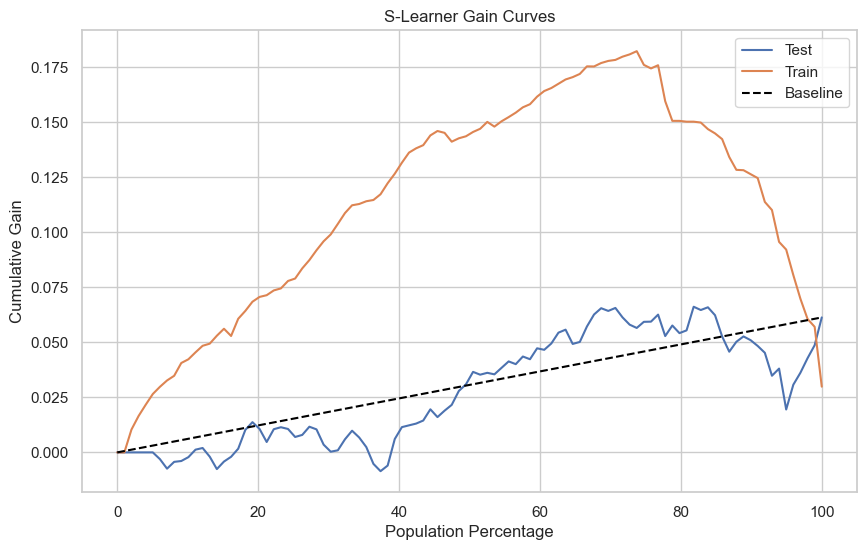

In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def fit_s_learner(X, t, y, model=None):
    """Fit the S-Learner model"""
    # Use a default RandomForestRegressor if no model is provided
    if model is None:
        model = RandomForestRegressor(
            n_estimators=100,
            max_depth=None,
            min_samples_split=2,
            random_state=42
        )
    
    # Add treatment indicator to the feature set
    X_with_t = X.copy()
    X_with_t['treatment'] = t
    

    # Train the model
    model.fit(X_with_t, y)
    return model

def predict_potential_outcomes(model, X):
    """Predict potential outcomes"""
    # Create datasets for treatment = 0 and treatment = 1
    X_control = X.copy()
    X_treatment = X.copy()
    X_control['treatment'] = 0
    X_treatment['treatment'] = 1

    # Predict outcomes
    y0 = model.predict(X_control)
    y1 = model.predict(X_treatment)
    return y0, y1

def estimate_cate(model, X):
    """Estimate CATE."""
    y0, y1 = predict_potential_outcomes(model, X)
    return y1 - y0

def calculate_gain_curve(df, x_points):
    """Calculate gain curve based on CATE estimates."""
    size = len(df)
    ordered_df = df.sort_values('cate', ascending=False)
    gains = []
    for frac in x_points:
        n_samples = int(np.ceil(frac * size))
        if n_samples < 30:  # Minimum threshold for reliable estimates
            gains.append(0)
        else:
            subset = ordered_df.head(n_samples)
            gain = elast(subset, 'rm_lfp', 'post_policy') * (n_samples / size)
            gains.append(gain)
    return np.array(gains)

def run_s_learner_analysis(propensity_data, X, test_size=0.2, n_points=100):
    """Run S-Learner analysis and generate gain curves."""
    # Extract necessary columns
    y = propensity_data['rm_lfp'].values
    t = propensity_data['post_policy'].values

    
    valid_mask = ~pd.isna(y)
    y_clean = y[valid_mask]
    t_clean = t[valid_mask]
    X_clean = X.loc[valid_mask]

    
    X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
        X_clean, y_clean, t_clean, test_size=test_size, random_state=42
    )

    
    model = fit_s_learner(X_train, t_train, y_train)

    # Estimate CATE for train and test sets
    cate_train = estimate_cate(model, X_train)
    cate_test = estimate_cate(model, X_test)

    # Create DataFrames for train and test sets
    train_df = pd.DataFrame({'cate': cate_train, 'rm_lfp': y_train, 'post_policy': t_train})
    test_df = pd.DataFrame({'cate': cate_test, 'rm_lfp': y_test, 'post_policy': t_test})

    # Generate cumulative gain curves
    x = np.linspace(0, 1, n_points)
    gain_curve_train = calculate_gain_curve(train_df, x)
    gain_curve_test = calculate_gain_curve(test_df, x)

    # Calculate baseline elasticity for test set
    baseline_elast = elast(test_df, 'rm_lfp', 'post_policy')

    # Plot the gain curves
    plt.figure(figsize=(10, 6))
    x_plot = x * 100  # Convert to percentages for better visualization

    plt.plot(x_plot, gain_curve_test, label='Test', color='C0')
    plt.plot(x_plot, gain_curve_train, label='Train', color='C1')
    plt.plot([0, 100], [0, baseline_elast], linestyle='--', color='black', label='Baseline')

    plt.xlabel('Population Percentage')
    plt.ylabel('Cumulative Gain')
    plt.title('S-Learner Gain Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return analysis results
    return {
        'model': model,
        'train_data': train_df,
        'test_data': test_df,
        'gain_curves': {'train': gain_curve_train, 'test': gain_curve_test},
        'baseline_elast': baseline_elast
    }


results = run_s_learner_analysis(propensity_data, X_psm)


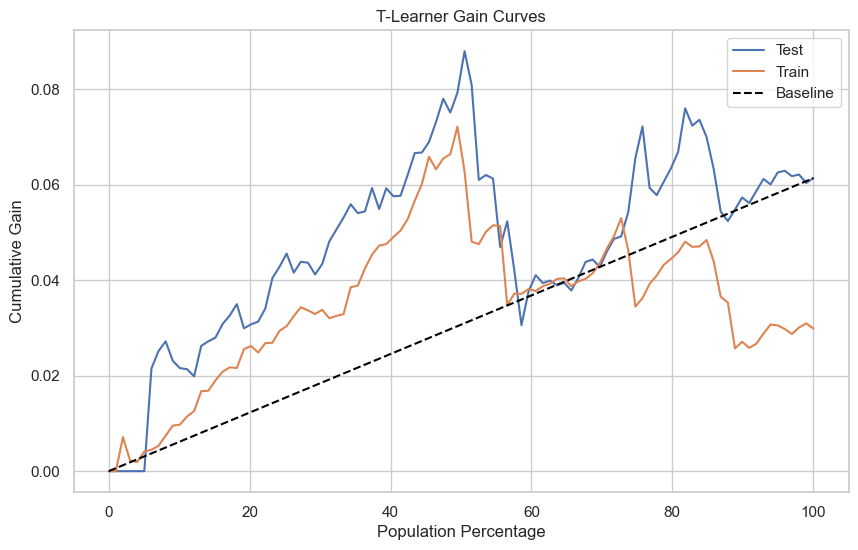

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def fit_t_learner(X, t, y, model_control=None, model_treat=None):
    """Fit separate models for treatment and control groups in a T-Learner."""
    # Default models if not provided
    if model_control is None:
        model_control = RandomForestRegressor(
            n_estimators=100,
            max_depth=2,
            min_samples_leaf=60,
            random_state=42
        )
    if model_treat is None:
        model_treat = RandomForestRegressor(
            n_estimators=100,
            max_depth=2,
            min_samples_leaf=60,
            random_state=42
        )

    # Create masks for treatment and control groups
    treat_mask = t == 1
    control_mask = t == 0


    # Fit control model
    X_control = X[control_mask]
    y_control = y[control_mask]
    model_control.fit(X_control, y_control)

    # Fit treatment model
    X_treat = X[treat_mask]
    y_treat = y[treat_mask]
    model_treat.fit(X_treat, y_treat)

    return model_control, model_treat

def predict_potential_outcomes(X, model_control, model_treat):
    
    y0 = model_control.predict(X)
    y1 = model_treat.predict(X)
    return y0, y1

def estimate_cate(X, model_control, model_treat):
    
    y0, y1 = predict_potential_outcomes(X, model_control, model_treat)
    return y1 - y0

def calculate_gain_curve(df, x_points):
    
    size = len(df)
    ordered_df = df.sort_values('cate', ascending=False)
    gains = []
    for frac in x_points:
        n_samples = int(np.ceil(frac * size))
        if n_samples < 30:
            gains.append(0)
        else:
            subset = ordered_df.head(n_samples)
            gain = elast(subset, 'rm_lfp', 'post_policy') * (n_samples / size)
            gains.append(gain)
    return np.array(gains)

def run_t_learner_analysis(propensity_data, X, test_size=0.2, n_points=100):
  
    y = propensity_data['rm_lfp'].values
    t = propensity_data['post_policy'].values

   
    valid_mask = ~pd.isna(y)
    y_clean = y[valid_mask]
    t_clean = t[valid_mask]
    X_clean = X.loc[valid_mask]

    
    X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
        X_clean, y_clean, t_clean, test_size=test_size, random_state=42
    )

    # Fit T-Learner models
    model_control, model_treat = fit_t_learner(X_train, t_train, y_train)

    # Estimate CATE for train and test sets
    cate_train = estimate_cate(X_train, model_control, model_treat)
    cate_test = estimate_cate(X_test, model_control, model_treat)

    # Create DataFrames
    train_df = pd.DataFrame({'cate': cate_train, 'rm_lfp': y_train, 'post_policy': t_train})
    test_df = pd.DataFrame({'cate': cate_test, 'rm_lfp': y_test, 'post_policy': t_test})

    # Calculate gain curves
    x = np.linspace(0, 1, n_points)
    gain_curve_train = calculate_gain_curve(train_df, x)
    gain_curve_test = calculate_gain_curve(test_df, x)

    # Calculate baseline elasticity
    baseline_elast = elast(test_df, 'rm_lfp', 'post_policy')

    # Plot gain curves
    plt.figure(figsize=(10, 6))
    x_plot = x * 100  
    plt.plot(x_plot, gain_curve_test, label='Test', color='C0')
    plt.plot(x_plot, gain_curve_train, label='Train', color='C1')
    plt.plot([0, 100], [0, baseline_elast], linestyle='--', color='black', label='Baseline')
    plt.xlabel('Population Percentage')
    plt.ylabel('Cumulative Gain')
    plt.title('T-Learner Gain Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        'models': {'control': model_control, 'treatment': model_treat},
        'train_data': train_df,
        'test_data': test_df,
        'gain_curves': {'train': gain_curve_train, 'test': gain_curve_test},
        'baseline_elast': baseline_elast
    }


results = run_t_learner_analysis(propensity_data, X_psm)


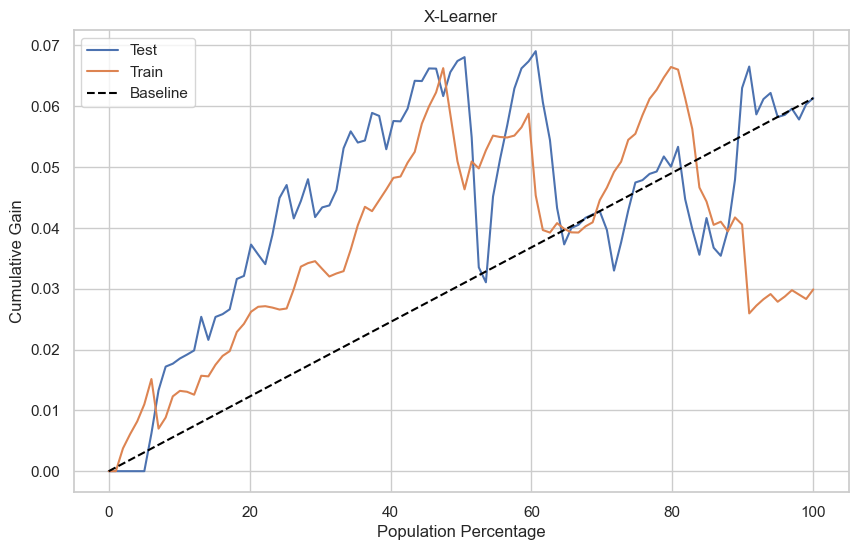

In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def fit_first_stage(X, y, model=None):
    # Fit the first-stage model
    if model is None:
        model = RandomForestRegressor(
            n_estimators=100, max_depth=2, min_samples_leaf=60, random_state=42
        )
    model.fit(X, y)
    return model

def fit_second_stage(X, D, model=None):
    # Fit the second-stage model
    if model is None:
        model = RandomForestRegressor(
            n_estimators=100, max_depth=2, min_samples_leaf=60, random_state=42
        )
    model.fit(X, D)
    return model

def estimate_cate(X, model_0_second, model_1_second):
    # Estimate CATE
    tau_0 = model_0_second.predict(X)
    tau_1 = model_1_second.predict(X)
    return (tau_0 + tau_1) / 2

def run_x_learner_analysis(data, X, test_size=0.2, n_points=100):
    y, t = data['rm_lfp'].values, data['post_policy'].values
    valid_mask = ~pd.isna(y)
    y, t, X = y[valid_mask], t[valid_mask], X.loc[valid_mask]
    
    X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
        X, y, t, test_size=test_size, random_state=42
    )
    
    
    treat_mask, control_mask = t_train == 1, t_train == 0
    X_treat, X_control = X_train[treat_mask], X_train[control_mask]
    y_treat, y_control = y_train[treat_mask], y_train[control_mask]
    
    # First stage
    model_0_first = fit_first_stage(X_control, y_control)
    model_1_first = fit_first_stage(X_treat, y_treat)
    
   
    y1_control = model_1_first.predict(X_control)
    y0_treat = model_0_first.predict(X_treat)
    D_control = y1_control - y_control
    D_treat = y_treat - y0_treat
    
    # Second stage
    model_0_second = fit_second_stage(X_control, D_control)
    model_1_second = fit_second_stage(X_treat, D_treat)
    
    
    cate_train = estimate_cate(X_train, model_0_second, model_1_second)
    cate_test = estimate_cate(X_test, model_0_second, model_1_second)
    
    train_df = pd.DataFrame({'cate': cate_train, 'rm_lfp': y_train, 'post_policy': t_train})
    test_df = pd.DataFrame({'cate': cate_test, 'rm_lfp': y_test, 'post_policy': t_test})
    
    
    def calculate_gain_curve(df, x_points):
        df_sorted = df.sort_values('cate', ascending=False)
        gains = []
        for frac in x_points:
            n_samples = int(np.ceil(frac * len(df)))
            if n_samples < 30:
                gains.append(0)
            else:
                subset = df_sorted.head(n_samples)
                gain = elast(subset, 'rm_lfp', 'post_policy') * (n_samples / len(df))
                gains.append(gain)
        return np.array(gains)
    
    x = np.linspace(0, 1, n_points)
    gain_curve_train = calculate_gain_curve(train_df, x)
    gain_curve_test = calculate_gain_curve(test_df, x)
    
    
    baseline_elast = elast(test_df, 'rm_lfp', 'post_policy')
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(x * 100, gain_curve_test, color='C0', label='Test')
    plt.plot(x * 100, gain_curve_train, color='C1', label='Train')
    plt.plot([0, 100], [0, baseline_elast], linestyle='--', color='black', label='Baseline')
    plt.xlabel('Population Percentage')
    plt.ylabel('Cumulative Gain')
    plt.title('X-Learner')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return {
        'models': (model_0_first, model_1_first, model_0_second, model_1_second),
        'train_data': train_df,
        'test_data': test_df,
        'gain_curves': {'train': gain_curve_train, 'test': gain_curve_test},
        'baseline_elast': baseline_elast
    }

results = run_x_learner_analysis(propensity_data, X_psm)
